<h1>Projeto de Aprendizado de Máquina</h1>

### 2º semestre de 2022

#### Grupo formado por:
        Ana Clara Loponi - 220073
        Ana Clara Brandão - 220069
        Heitor Bernardes - 220052
        Lorraine Casseano - 220036
        
<h2>Dengue: O uso de ferramentas estatísticas para a propensão de uma das doenças mais negligenciadas do Brasil.</h2>
<h3>Usando Machine Learning para uma previsão de casos de Dengue em Campinas/SP</h3>

<ht> Entende-se que a Dengue é uma das doenças mais negligenciadas do Brasil, visto que, em todos os anos se observa um pico no número de casos confirmados. Observe que o padrão dos picos é referenciado com as características climáticas de épocas do ano. Com base nisso, é uma ideia de desenvolver um plano preventivo baseado nos dados testados.</ht>

<h2> Treinando Modelos II</h2>
<h3> Aprendizado não-supervisionado </h3>
<ht> Iniciando os processos de machine learning, foram treinados quatro diferentes modelos de aprendizado (PCA, k-Means, LOF, IF), juntamente com algumas análises dos respectivos modelos. </ht>

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import IsolationForest

In [2]:
dados1 = pd.read_excel("dataset_dengue_categorico.xlsx")

#dados1

In [3]:
# Definir datasets de treino e teste, e hiperparâmetros gerais para todos os teste   

TAMANHO_TESTE = 0.15 # quantidade de dados usados para o teste (15%)
SEMENTE_ALEATORIA = 469
FEATURES = ["chuva", "temperatura-media", "temperatura-mininima", "temperatura-maxima"]
TARGET = ["cc"]

df = dados1

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)


df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

In [4]:
# Normalizador 
# Para esta tranformação, os dados precisam estar normalizados 

X = df.reindex(FEATURES, axis=1)
sc = StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)

In [5]:
# Transformação PCA
pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

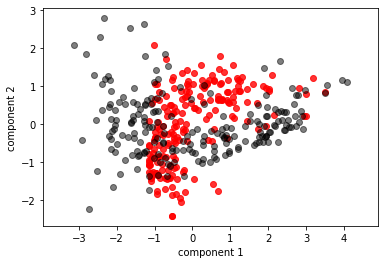

In [22]:
# Gráfico

plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.8, color="red")
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color="black")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal');

Análise dos resultados do gráfico
    
O gráfico apresenta uma solução bidemensional para os resultados do normalizador e da PCA, com as cores vermelho e preto. Em primeira análise, os dados foram espalhados maximizando a variância. Não há uma relação clara, utilizando somente essse gráfico.

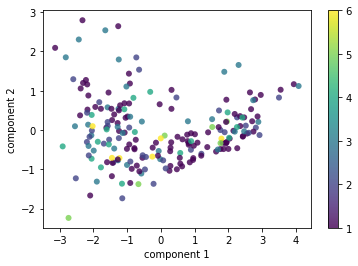

In [7]:
# Gráfico disperso, o padrão de cores corresponde aos classificadores
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.8, c=df["cc"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

Análise dos resultados do gráfico
    
Esse novo gráfico agrupa os dados por cores, em um degradê de roxo à amarelo. Contudo, não é possível perceber relação entre os grupos formados. Um dado roxo está completamente distante de outro roxo, e todos parecem espalhados, sobrepondo a área azul, por exemplo. Então, nenhuma conclusão pode ser tirada, salvo pela certeza de que essa não é a melhor transformação para o tipo de feature apresentado.

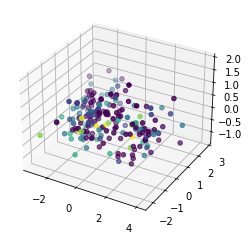

In [8]:
# Versão 3D

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df["cc"].values)

In [9]:
# Peso das Features

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca2 = X_pca
X_pca2 = pd.DataFrame(X_pca2, columns=component_names)
X_pca2.head()

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
chuva,-0.383303,0.915135,0.122550,0.024267
temperatura-media,-0.562388,-0.213220,-0.008599,-0.798864
temperatura-mininima,-0.522174,-0.131039,-0.735971,0.410499
temperatura-maxima,-0.513939,-0.316061,0.665773,0.438997


array([<AxesSubplot:title={'center':'Variancia explicada'}, xlabel='Componente'>,
       <AxesSubplot:title={'center':'Variância acumulada'}, xlabel='Componente'>],
      dtype=object)

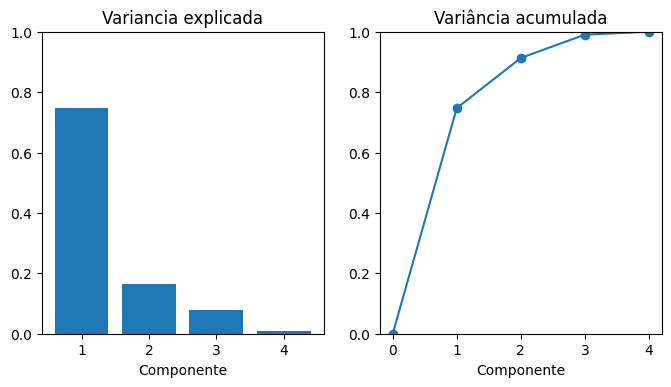

In [10]:
# Análise da variancia 

def plot_variance(pca, width=8, dpi=100):
    # Criar figura
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Fazer o cálculo da variância explicada
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", 
        title="Variancia explicada", 
        ylim=(0.0, 1.0)
    )
    
    # Variância acumulada
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", 
        title="Variância acumulada", 
        ylim=(0.0, 1.0)
    )
    
    # Detalhes da figura
    fig.set(figwidth=8, dpi=100)
    return axs

# Graficar
plot_variance(pca)

Análise dos resultados do gráfico
    
A variância é grande em todos os casos, como já era esperado. Tudo dentro do esperado. 

### K-Means

In [11]:
sc = StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)

In [12]:
n_clusters=3  #Define três clusters

kmeans = KMeans(            #Inicializando o K-Means
    n_clusters=n_clusters,  #Definindo número de clusters
    init='random',          #Inicialização randomica, aqui você pode tentar o K-Means++ :)
    n_init=10,              #Número de inicializações
    max_iter=300,           #Número máximo de iterações
    tol=1e-04,              #Tolerância para variação da coordenada dos centróides para definir a convergência
    random_state=0          #Define a semente aleatória
)

y_kmeans = kmeans.fit_predict(X_norm) #Fita o K-Means

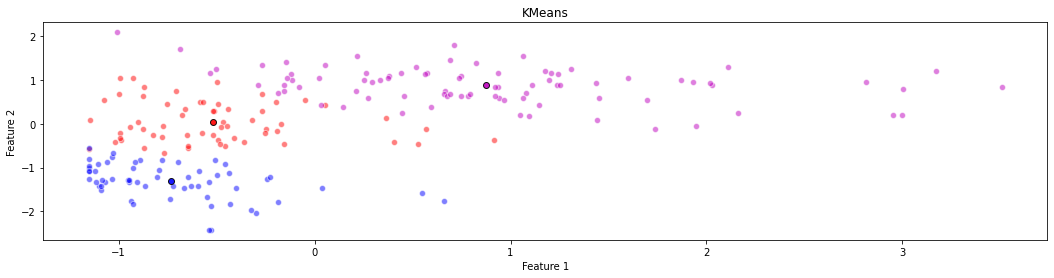

In [13]:
centroids = kmeans.cluster_centers_ #Extraindo os centróides do K-Means
labels = pairwise_distances_argmin(X_norm, centroids) #Usando a função pairwise_distances_argmin 
                                                      #para dar os labels aos clusters
colors = ["r", "m", "b", "y", "k"] #Definindo a paleta de cores

fig = plt.figure(figsize=(18, 4)) #Definindo a figura e seu tamanho
ax = fig.add_subplot()             #Criando um subplot

for k, col in zip(range(n_clusters), colors): #Desempacotando a lista de número de cluster e cores.
    my_members = labels == k  #Define quais pontos são membros de cada cluster
    #print(my_members)        #Descomente essa linha para entender como se comporta a variável my_members
    cluster_center = centroids[k] #Pega as coordenadas do centróide k
    ax.plot(                      #Plota os pontos do centróide k
        X_norm[my_members, 0],    #Coordenada do eixo-x
        X_norm[my_members, 1],    #Coordenada do eixo-y
        markerfacecolor=col,      #Define a cor do ponto
        marker="o",               #Define o estilo do ponto
        markeredgecolor="w",      #Define a cor de contorno do ponto
        linewidth=0,               #Largura de linha zero, para não ligar os pontos
        alpha=0.5
    )
    ax.plot(                      #Plotando os centróides
        cluster_center[0],        #Coordenada x do centróide
        cluster_center[1],        #Coordenada y do centróide
        marker="o",               #Define estilo do ponto
        markerfacecolor=col,      #Define cor do ponto
        markeredgecolor="k",      #Define a cor do contorno do ponto
        markersize=6,             #Define o tamanho do ponto
        linewidth=0,               #Largura de linha zero, para não ligar os pontos
        alpha=0.9
    )

ax.set_title("KMeans")  #Título do gráfico
plt.xlabel('Feature 1') #Nome da componente x
plt.ylabel('Feature 2') #Nome da componente y

plt.show() #Mostrar o gráfico

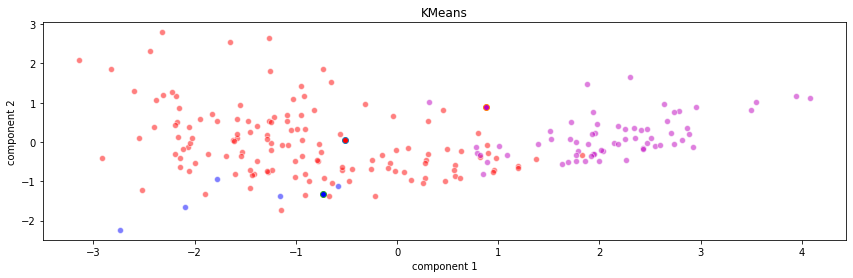

In [14]:
centroids = kmeans.cluster_centers_
labels = pairwise_distances_argmin(X_pca, centroids)
colors = ["r", "m", "b", "y", "k"]

fig = plt.figure(figsize=(14.4, 4))
ax = fig.add_subplot()

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0],
        X_pca[my_members, 1],
        "w", 
        markerfacecolor=col,
        marker="o",
        alpha = 0.5,
        linewidth=0)
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markersize=6,
        alpha = 1.0,
        linewidth=0
    )

ax.set_title("KMeans")
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.show()

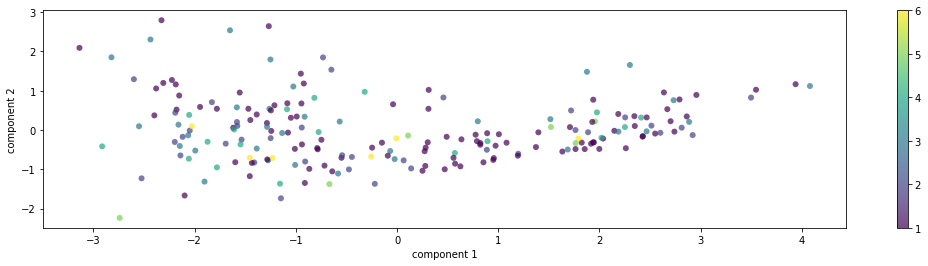

In [15]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot()

plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.7, c=df["cc"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

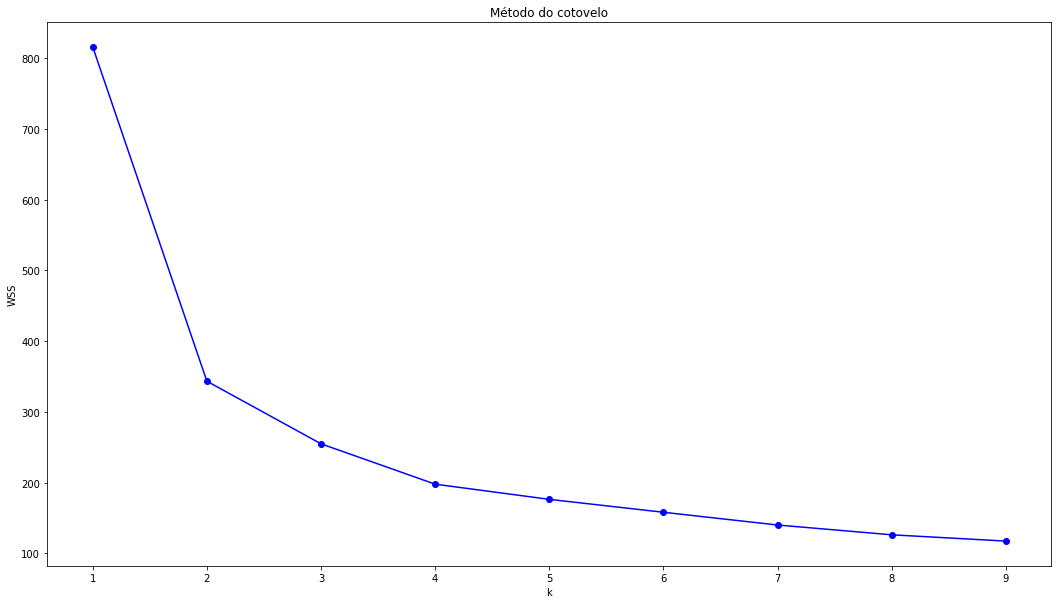

In [16]:
WSS = []  #Inicia uma lista vazia, para acumularmos valores.

for k in range(1,10): #Vamos fazer para 1 a 9 clusters.
    kmeans = KMeans(  #Inicializa o K-Means, como já explicado antes
        n_clusters=k, 
        init='random',
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0
    )
    y_kmeans = kmeans.fit_predict(X_pca) #Fita o K-Means
    WSS.append(kmeans.inertia_)          #Obtem a WSS e acumula na lista inicializada 
    
plt.figure(figsize=(18,10))              #Define o tamanho da figura
plt.plot(range(1,10), WSS, '-bo')        #Define o plot
plt.xlabel('k')                          #Nome da coordenada x
plt.ylabel('WSS')                        #Nome da coordenada y
plt.title('Método do cotovelo')          #Título do gráfico
plt.show()                               #Mostra o gráfico

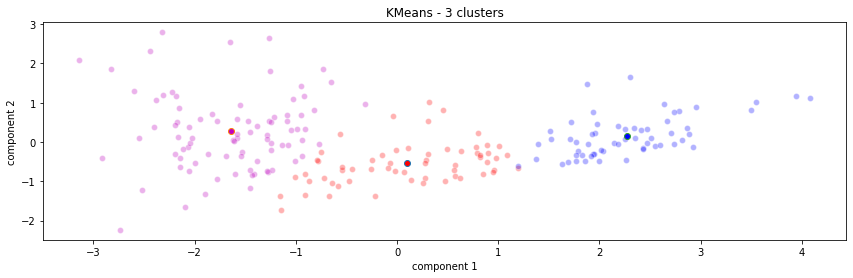

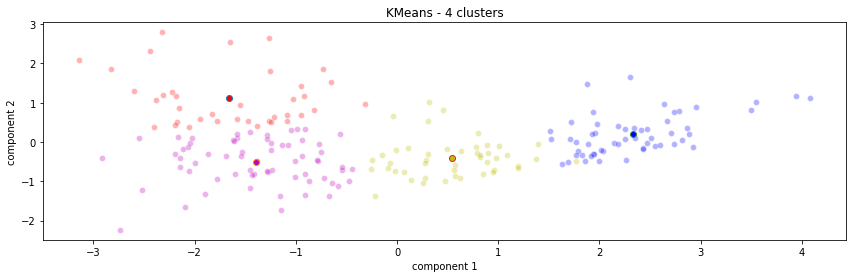

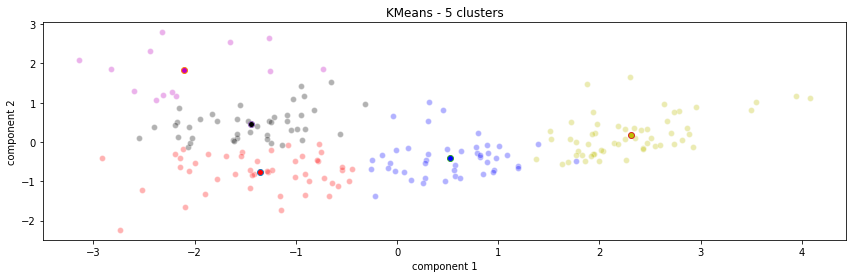

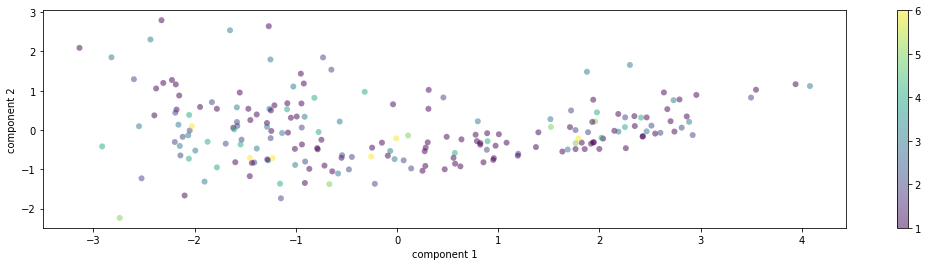

In [17]:
for numberofclusters in range(3,6):

    n_clusters=numberofclusters

    kmeans = KMeans(
        n_clusters=n_clusters, 
        init='random',
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0
    )

    y_kmeans = kmeans.fit_predict(X_pca)

    centroids = kmeans.cluster_centers_
    labels = pairwise_distances_argmin(X_pca, centroids)
    colors = ["r", "m", "b", "y", "k"]

    fig = plt.figure(figsize=(14.4, 4))
    ax = fig.add_subplot()

    for k, col in zip(range(n_clusters), colors):
        my_members = labels == k
        cluster_center = centroids[k]
        ax.plot(
            X_pca[my_members, 0],
            X_pca[my_members, 1],
            "w", 
            markerfacecolor=col,
            marker="o",
            alpha = 0.3,
            linewidth=0)
        ax.plot(
            cluster_center[0],
            cluster_center[1],
            "o",
            markerfacecolor=col,
            markersize=6,
            alpha = 1.0,
            linewidth=0
        )
    title = 'KMeans - ' + str(numberofclusters) + " clusters"
    ax.set_title(title)
    plt.xlabel('component 1')
    plt.ylabel('component 2')

    plt.show()


fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot()

plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.5, c=df["cc"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

### Algoritmo Local Outlier Factor (LOF)

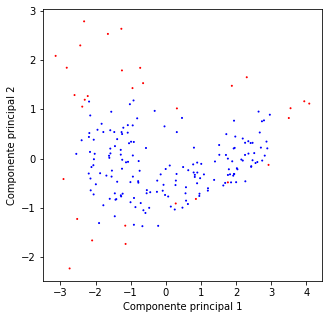

In [18]:
# precisamos indicar a fração de outliers, vamos estimar que seja 1%
FRACAO_OUTLIERS = 0.15

# precisamos também indicar o número de vizinhos que serão considerados
N_VIZINHOS = 50

CORES = np.array(["red", "blue"])

modelo_lof = LocalOutlierFactor(
    n_neighbors=N_VIZINHOS,
    contamination=FRACAO_OUTLIERS,
)

modelo_lof.fit(X_pca)
previsao = modelo_lof.fit_predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=1,
    color=CORES[(previsao + 1) // 2],
)

eixo.set_xlabel("Componente principal 1")
eixo.set_ylabel("Componente principal 2")
plt.show()

### Algoritmo Isolation Forest (IF)

In [19]:
CORES = np.array(["red", "blue"])
COM_BORDA_DE_PREVISAO = True # mude para True para ver a borda de previsão

# aqui que criamos o modelo de Isolation Forest
modelo_if = IsolationForest(
    contamination=FRACAO_OUTLIERS,
    random_state=SEMENTE_ALEATORIA,
)

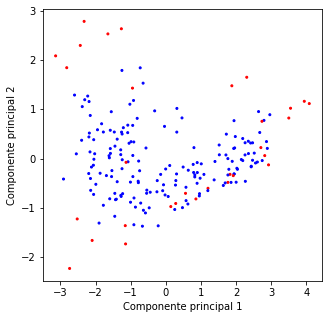

In [20]:
# precisamos indicar a fração de outliers, vamos estimar que seja 15%
FRACAO_OUTLIERS = 0.15

CORES = np.array(["red", "blue"])
COM_BORDA_DE_PREVISAO = True # mude para True para ver a borda de previsão

modelo_if = IsolationForest(
    contamination=FRACAO_OUTLIERS,
    random_state=SEMENTE_ALEATORIA,
)

# Ajustamos o modelo aos dados e realizamos a previsão
modelo_if.fit(X_pca)
previsao = modelo_if.predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=4,
    color=CORES[(previsao + 1) // 2],
)

eixo.set_xlabel("Componente principal 1")
eixo.set_ylabel("Componente principal 2")
plt.show()

### Para remover os valores anômalos

In [21]:
logic = previsao == 1
X_clean = X[logic]

print(X.shape)
print(X_clean.shape)

(204, 4)
(173, 4)


Apesar dessa possibilidade, os valores anômalos são congruentes com a realidade, portanto, não devem ser removidos.